In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from keras.layers import Input
from sklearn.preprocessing import RobustScaler
from scipy.ndimage import gaussian_filter
import cv2
import torch.nn.functional as F

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
"""Reads a Surfer 6 GRD (Golden Software Grid) file and extracts its data.
    
    Parses the ASCII grid file format used by Golden Software Surfer (version 6)

    Args:
        file_path (str): Path to the .grd file to be read.

    Returns:
        list: A list containing the following elements in order:
            - Nx (int): Number of grid columns
            - Ny (int): Number of grid rows
            - xMin (float): Minimum X coordinate
            - xMax (float): Maximum X coordinate
            - yMin (float): Minimum Y coordinate
            - yMax (float): Maximum Y coordinate
            - zMin (float): Minimum Z value in grid
            - zMax (float): Maximum Z value in grid
            - grid_data (numpy.ndarray): 2D array of grid values with shape (Ny, Nx)
    """
def read_surfer6_grd(file_path):
    with open(file_path, 'r') as f:
        # Format check
        header = f.readline().strip()
        if header != "DSAA":
            raise ValueError("Wrong file format Surfer GRD ('DSAA')")

        # Reading grid sizes
        Nx, Ny = map(int, f.readline().split())
        
        # Reading X, Y, Z ranges
        xMin, xMax = map(float, f.readline().split())
        yMin, yMax = map(float, f.readline().split())
        zMin, zMax = map(float, f.readline().split())

        # Reading grid data
        grid_data = np.loadtxt(f)
        
        # Dimension check
        if grid_data.shape != (Ny, Nx):
            raise ValueError(
                f"Correct size {Ny}x{Nx}, but {grid_data.shape}"
            )

    return [Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, grid_data]

"""Writes data to an ASCII grid file in Surfer 6 GRD format.

    Creates a Golden Software Surfer 6 compatible grid file (.grd)

    Args:
        Nx (int): Number of grid columns (cells in x-direction)
        Ny (int): Number of grid rows (cells in y-direction)
        xMin (float): Minimum X coordinate of the grid (left boundary)
        xMax (float): Maximum X coordinate of the grid (right boundary)
        yMin (float): Minimum Y coordinate of the grid (bottom boundary)
        yMax (float): Maximum Y coordinate of the grid (top boundary)
        zMin (float): Minimum Z value in the data (for scaling/display purposes)
        zMax (float): Maximum Z value in the data (for scaling/display purposes)
        data (array-like): 2D array of grid values with shape (Ny, Nx)
        file (str or file-like): Output file path or file object to write to
    """

def write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data, file):
    with open(file, "w") as f:
        f.write("DSAA" + '\n')
        f.write("%s %s" % (Nx, Ny) + '\n')
        f.write("%s %s" % (xMin, xMax) + '\n')
        f.write("%s %s" % (yMin, yMax) + '\n')
        f.write("%s %s" % (zMin, zMax) + '\n')
        for row in data:
            f.write(' '.join([str(t) for t in row]) + '\n')

"""Pads a 4D tensor to make dimensions multiples of specified value using circular padding.
    
    The function pads input tensor's height and width dimensions to the nearest multiple
    of the specified value using circular (toroidal) padding. Padding is distributed
    symmetrically when possible, with extra padding applied to bottom/right when needed.

    Args:
        tensor (torch.Tensor): Input 4D tensor of shape (N, C, H, W) to be padded
        multiple (int, optional): Target multiple for dimensions. Defaults to 192.

    Returns:
        torch.Tensor: Padded tensor with dimensions (N, C, H', W') where:
            - H' = H + pad_h (padded to multiple)
            - W' = W + pad_w (padded to multiple)
"""
def pad_to_multiple_circular(tensor, multiple=192):
    _, _, H, W = tensor.shape

    pad_h = (multiple - H % multiple) % multiple
    pad_w = (multiple - W % multiple) % multiple

    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    padded_tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='circular')
    return padded_tensor


"""Crops a 2D tensor back to its original dimensions after padding.
    
    Reverses symmetric padding by cropping from center. Assumes the tensor was
    previously padded with symmetric padding (extra padding on bottom/right if odd).

    Args:
        tensor (torch.Tensor): Padded 2D tensor of shape (H', W')
        original_h (int): Original height before padding
        original_w (int): Original width before padding

    Returns:
        torch.Tensor: Cropped tensor of shape (original_h, original_w)

"""
def crop_to_original(tensor, original_h, original_w):
    H, W = tensor.shape
    pad_h = H - original_h
    pad_w = W - original_w

    top = pad_h // 2
    left = pad_w // 2

    return tensor[top:top+original_h, left:left+original_w]

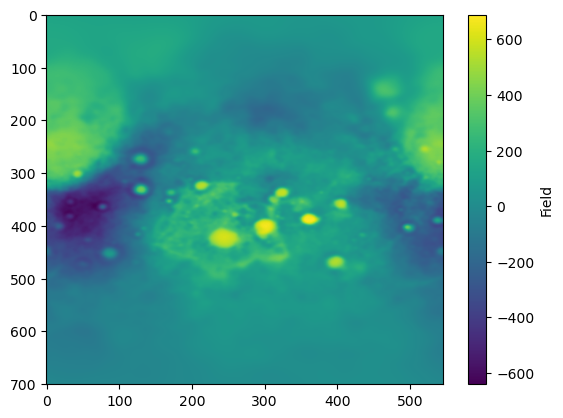

Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), 

In [12]:
# Load data
file_path = "../data/dGb255_Merc_dx20km.grd"

# Unpacking the results
Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data = read_surfer6_grd(file_path)

data = cv2.blur(data, (5, 5))

plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Field') 
plt.show()

# Load the model
model = torch.load('../weights/model_600_Unet_EffNetb2-ВСЕ0p85_192.pth', weights_only=False)
model.to(device)
model.eval()

torch.Size([1, 1, 701, 546])
torch.Size([1, 1, 768, 576])
(768, 576)


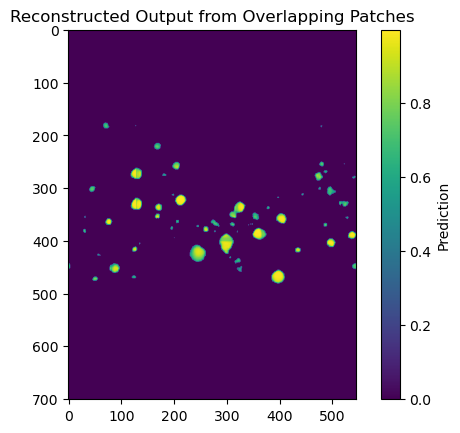

In [13]:
# Parameters for patches
patch_size = 192
overlap = 0.75
stride = int(patch_size * (1 - overlap))

# Transform into a tensor
data_tensor = torch.from_numpy(data).float().unsqueeze(0).unsqueeze(0).to(device)
print(data_tensor.shape)

data_tensor_padded = pad_to_multiple_circular(data_tensor, multiple=patch_size)
print(data_tensor_padded.shape)

_, _, H, W = data_tensor_padded.shape
output_map = np.zeros((H, W))
weight_map = np.zeros((H, W))

# Applying the model to patches
with torch.no_grad():
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = data_tensor_padded[:, :, y:y+patch_size, x:x+patch_size]
            
            if patch.shape[-1] != patch_size or patch.shape[-2] != patch_size:
                continue  # Skip if patch goes out of bounds

           # Min-max normalization for each patch
            patch_np = patch.squeeze().cpu().numpy()
            patch_np = (patch_np - patch_np.min()) / (patch_np.max() - patch_np.min() + 1e-8) 

            patch_np_1ch = patch_np[np.newaxis, ...]
            patch_tensor_1ch = torch.from_numpy(patch_np_1ch).unsqueeze(0).float().to(device) 
            
            output = model(patch_tensor_1ch)
            output_np = output.squeeze().cpu().numpy()

            output_map[y:y+patch_size, x:x+patch_size] += output_np
            weight_map[y:y+patch_size, x:x+patch_size] += 1

# Avoiding division by zero
weight_map[weight_map == 0] = 1
final_output = output_map / weight_map
final_output[final_output < 0.5] = 0

print(final_output .shape)
final_output = crop_to_original(final_output, Ny, Nx)

# Visualization
plt.imshow(final_output, cmap='viridis')
plt.colorbar(label='Prediction')
plt.title("Reconstructed Output from Overlapping Patches")
plt.show()

In [14]:
"""Save the results to surfer grid"""
filename = '25_06_01_res_600_Unet_Effb2_192.grd'
write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, final_output, filename)

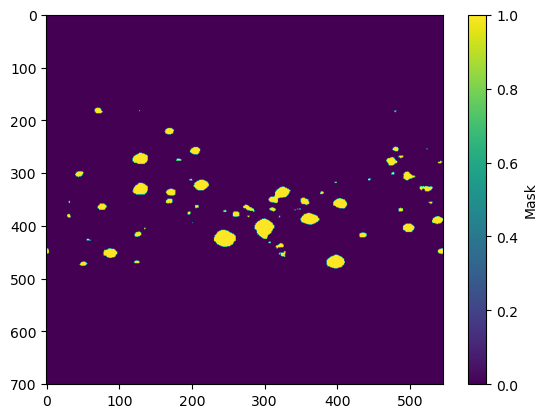

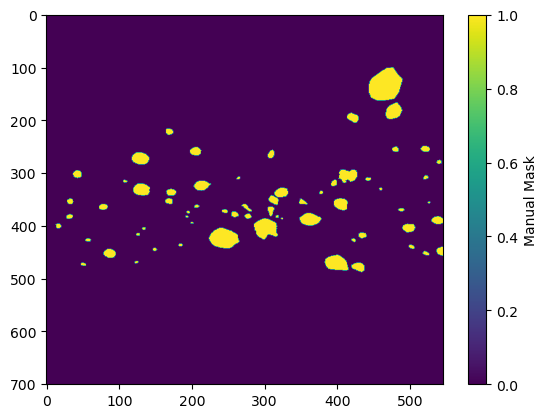

0.428


In [21]:
"""Accuracy assessment by IoU metric"""

from sklearn.metrics import jaccard_score

file_manual_path = '../data/Manual_mask_dx20km.grd'
params = read_surfer6_grd(file_manual_path)

Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data_man = params
data_man[data_man == 1.70141e+38] = 0

params = read_surfer6_grd(filename)

Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data_res = params

data_res[data_res == 1.70141E+38] = 0

data_res = np.where((data_res >= 0.2) & (data_res != 0), 1, 0)


plt.imshow(data_res, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Manual Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    data_res.flatten(), 
    average='binary'  # For binary segmentation
    )
print(round(error, 3))